In [1]:
import numpy as np
import qibo
from boostvqe.models.dbi.group_commutator_iteration_transpiler import DoubleBracketRotationType

In [3]:
from boostvqe.utils import *
gci = initialize_gci_from_vqe()




[Qibo 0.2.9|INFO|2024-06-24 13:36:08]: Using numpy backend on /CPU:0
INFO:qibo.config:Using numpy backend on /CPU:0


In the VQE numpy


NameError: name 'vqe_energy' is not defined

In [6]:
def print_vqe_comparison_report(gci, nmb_digits_rounding = 2):
    gci_loss = gci.loss()
    return_values = dict(
    gci_loss = gci_loss,
    vqe_energy = gci.vqe_energy,
    target_energy = gci.h.target_energy,
    diff_vqe_target = gci.vqe_energy-gci.h.target_energy,
    diff_gci_target = gci_loss-gci.h.target_energy,
    gap = gci.h.gap
    diff_vqe_target_perc = abs(gci.vqe_energy-gci.h.target_energy)/abs(gci.h.target_energy)*100,
    diff_gci_target_perc = abs(gci_loss-gci.h.target_energy)/abs(gci.h.target_energy)*100,
    fidelity_witness_vqe = gnd_state_fidelity_witness(gci,gci.vqe_energy),
    fidelity_witness_gci = gnd_state_fidelity_witness(gci,gci.vqe_energy),
    fidelity_vqe = gnd_state_fidelity(gci, input_state = gci.vqe.circuit().state()),
    fidelity_gci = gnd_state_fidelity(gci),
 )
    print(f"VQE energy is {return_values['vqe_energy']} and the DBQA yields {return_values['gci_loss']}. \n\
            The target energy is {return_values['target_energy']} which means the difference is for VQE \
            {return_values['diff_vqe_target']} and of the DBQA {return_values['diff_gci_target']} \
            which can be compared to the spectral gap {return_values['gap']}.\n\
            The relative difference is for VQE {return_values['diff_vqe_target_perc']}% \
            and for DBQA {return_values['diff_gci_target_perc']}%.\
            The energetic fidelity witness of the ground state is: \n\
            - for the VQE  {return_values['fidelity_witness_vqe']} \n\
            - for DBQA {return_values['fidelity_witness_gci']}\n\
            The true fidelity is \n\
            - for the VQE  {return_values['fidelity_witness_vqe']} (see boostvqe issue https://github.com/qiboteam/boostvqe/issues/51 why this value seems wrong)\n\
            - for DBQA {return_values['fidelity_witness_gci']}\n\{round(gnd_state_fidelity(gci),5)} \n\
            and DBQA {round(gnd_state_fidelity_witness(gci,gci_loss),5)}\
")
    gci.print_gate_count_report()   

print_vqe_comparison_report(gci)


def gnd_state_fidelity_witness(gci,e_state = None):
    if e_state is None:
        e_state = gci.loss()
    return 1 - (e_state-gci.h.target_energy) / gci.h.gap

def gnd_state_fidelity(gci, input_state = None):
    if input_state is None:
        input_state = gci.get_composed_circuit()().state()
    return abs( gci.h.ground_state.T.conj() @ input_state )**2

NameError: name 'gci_loss' is not defined

In [ ]:
from boostvqe.models.dbi.group_commutator_iteration_transpiler import *
b_list = [1+np.sin(x/3)for x in range(10)]
eo_d_m_field = MagneticFieldEvolutionOracle(b_list)
eo_d_nn = IsingNNEvolutionOracle(b_list, b_list)

Just finished the selection: better loss -14.992226029274104 for mode DoubleBracketRotationType.group_commutator_third_order_reduced,                  with duration s=0.005222222222222222, and eo_d name = H_ClassicalIsing(B,J)


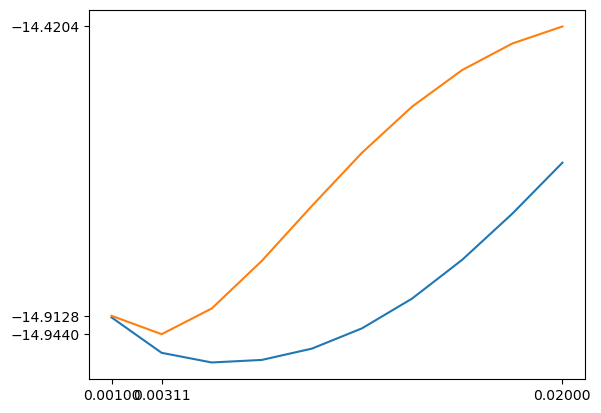

In [ ]:
mode_dbr, minimizer_s, min_loss, eo_d = select_recursion_step_gd_circuit(
    gci, mode_dbr_list = [DoubleBracketRotationType.group_commutator_third_order_reduced, 
                          DoubleBracketRotationType.group_commutator],
    eo_d = eo_d_nn,
    use_gd = False,
    step_grid = np.linspace(1e-3,2e-2,10),
    please_be_visual = True)


In [ ]:

step_grid = np.linspace(1e-3,2e-2,10)
mode = gci.mode_double_bracket_rotation
s, l, ls = gci.choose_step(d = eo_d,step_grid = step_grid, mode_dbr = mode)
n_local= 1
params =eo_d.b_list
s_min, s_max = step_grid[0], step_grid[-1]
lr_range = (1e-3, 1)
lr_min, lr_max = lr_range[0], lr_range[-1]
eo_d, s, l, eval_dict = choose_gd_params(gci, n_local, params, l, s, s_min, s_max, lr_min, lr_max, threshold =1e-4, max_eval = 10)

loss_0 = l
s_0 = s
s_min=1e-4
s_max=2e-2
lr_min=1e-4
lr_max=1
threshold=1e-4
max_eval=10
please_be_adaptive = True
please_be_verbose = False

evaluated_points = {}
max_eval = int(np.sqrt(max_eval))
grad = gradient_numerical(gci.loss, n_local, params, loss_0, s_0)

def loss_func_lr(lr):
    filtered_entries = {k:v for k, v in evaluated_points.items() if k[0]==lr}
    if len(filtered_entries) > 0:
        return min(filtered_entries.values())
    elif lr < 0:
        return float("inf")
    else:
        params_eval = (1 - grad*lr) * deepcopy(params)
        eo_d = get_gd_evolution_oracle(n_local, params_eval)
        # given lr find best possible s_min and loss_min
        if please_be_adaptive:
            best_s, best_loss, evaluated_points_s, exit_criterion = adaptive_binary_search(lambda s: gci.loss(s, eo_d) if s>0 else float("inf"), 
                                                                                            threshold, s_min, s_max, max_eval)
        else:
            best_s, best_loss, evaluated_points_s = gci.choose_step(d = eo_d,s_min=1e-4, s_max=2e-2, max_eval = max_eval)

        for s,l in evaluated_points_s.items():
            if l < 0:
                evaluated_points[(lr, s)] = l
        if please_be_verbose:
            print(f"For lr = {lr} found optimal s = {best_s} yielding loss = {best_loss} after terminating with {exit_criterion}")
    return best_loss

best_lr, best_loss, _ ,exit_criterion = adaptive_binary_search(loss_func_lr, threshold, lr_min, lr_max, max_eval)
if please_be_verbose:
    print(f"For lr = {lr} found optimal s = {best_s} yielding loss = {best_loss} after terminating with {exit_criterion}")
eo_d = get_gd_evolution_oracle(n_local, (1-grad*best_lr)*deepcopy(params))
# find best_s
for (lr, s), loss in evaluated_points.items():
    if lr == best_lr and loss == best_loss:
        best_s = s
print( eo_d, best_s, best_loss, evaluated_points)

<boostvqe.models.dbi.double_bracket_evolution_oracles.MagneticFieldEvolutionOracle object at 0x7eb05cc5fc80> 0.01005 -14.977361372969742 {(0.0001, 0.0001): -14.860422551928544, (0.0001, 0.01005): -14.954229814559074, (0.0001, 0.02): -14.769059208349297, (0.0001, 0.005075): -14.961484813561384, (0.0001, 0.015025): -14.88064951323977, (0.50005, 0.0001): -14.858670427201794, (0.50005, 0.01005): -14.967868665304206, (0.50005, 0.02): -14.971270526602416, (0.50005, 0.02995): -14.896903185325453, (1, 0.0001): -14.856899473569793, (1, 0.01005): -14.856944381831411, (1, 0.02): -14.856978361148478, (1, 0.02995): -14.857003800302875, (1, 0.039900000000000005): -14.857022565555194, (1, 0.049850000000000005): -14.857036108793519, (1, 0.059800000000000006): -14.857045556018758, (1, 0.06975): -14.857051778102464, (1, 0.07970000000000001): -14.857055447163292, (1, 0.08965000000000001): -14.85705708136069, (1, 0.09960000000000001): -14.85705708037561, (0.250075, 0.0001): -14.85954964082741, (0.250075, 

In [ ]:
gci.loss(best_s,eo_d)

-14.977361372969742

In [ ]:
params_eval = (1 - grad*best_lr) * deepcopy(params)
eo_d = get_gd_evolution_oracle(n_local, params_eval)
best_s, best_loss, evaluated_points_s, exit_criterion = adaptive_binary_search(lambda s: gci.loss(s, eo_d) if s>0 else float("inf"), 
                                                                                            threshold, s_min, s_max, max_eval)

In [ ]:
best_loss

-14.977361372969742